`f_` is the intended order to go through the notebooks if I forgot what I did in the future.

In [1]:
import util_thm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

# Inverting the $\beta, S$ conjugate pair
Eventually we are probably more interested in specifying the system by some initial entropy instead of the final temperature. This requires going from $(n_s; N_{tot}, \beta) \rightarrow (\mu_s, \mu_r, S_{tot})$ to $(n_s; N_{tot}, S_{tot}) \rightarrow (\mu_s, \mu_r, \beta)$. This mapping is unique since $S_{tot}$ is a monotonic function as a function of $\beta$ (, at least for $\beta > 0$).

I will also replace $\mu_s$ and $\mu_r$ by $V_{offset}$ and $\mu$.

I will do this by storing results in Dataframes, since
1. this allows me to compare scanning different things in the future easily (e.g. $V$, $t_p$)
2. I can save and read the Dataframes using pandas, so I don't have to do the same matching again in the future.

Eventually the actual inversion must be completed by interpolations.

## Reading data
Let's first start with the full $N - S_{tot}$ space scan for a fixed set of model parameters.

In [2]:
tnpspc = {  # tenpy specs used to generate folder names
    "geometry": "sawtooth",
    "spin": "spinless",      # "spinful", "spinless"
    "interacting": "NI",             # "I", "NI"
    "L": 25,
}
model_params = {
    "shift": -2.,
    "tp": 1.41421356237,
    "n_s": 0.6,#np.arange(0.3, 0.54, 0.02)
}

In [3]:
folder_name = f"{tnpspc['geometry']}_{tnpspc['spin']}_{tnpspc['interacting']}_L{tnpspc['L']}"
csv_name = f"tp{model_params['tp']}_shift{model_params['shift']}_ns{model_params['n_s']}.csv"
csv_path = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results",
                folder_name, csv_name)
df_match = pd.read_csv(csv_path)
# df_match = df_match.query("beta >= 0.")

# df_match

In [4]:
L_subregion = tnpspc['L']
N_s = model_params["n_s"] * 2 * L_subregion
beta_vals = df_match["beta"].to_numpy(dtype=float)
mask_beta = np.isclose(beta_vals, 20)
s2_tot_max_beta = df_match[mask_beta]["S2_tot"].to_numpy(dtype=float)
Ntot_max_beta = df_match[mask_beta]["Ntot"].to_numpy(dtype=float)

## The "pathological" behavior of flat band
In the case of non-interacting particles, the entropy in flat bands takes on a particularly simple expression (note that there are only $L$ states in the flat band),

$S_F = L [-(1 - n_r) \ln(1 - n_r) - n_r \ln n_r]$,

and is independent of the temperature.

In [5]:
def S_flat(L, n_r):
    n_f = 2 * np.maximum(0., n_r - 0.5)     # minimum density in the flat band
    return -L * ((1 - n_f) * np.log(1 - n_f) + n_f * np.log(n_f)) #/ 1.5 # this almost reproduces the blue dash

## Interpolation
I am scanning $S_{tot}$ instead of $s$ (entropy per particle) to make connection to the entropy capacity mentioned above.

For $\varsigma$, instead of interpolating $\varsigma$ directly, one should interpolate $s_s$ and $s_r$, and then find $\varsigma$ using its definition.

$\varsigma \equiv s_s / s - 1 = (s_s - s_r) / (s_s + s_r)$ (assume $L_r = L_s$)

But I'm lazy.

In [13]:
N_range = np.arange(N_s + 0. * L_subregion, N_s + 2 * L_subregion)
S_range = np.linspace(2.0, 18.0, 50) * (L_subregion / 25)

In [14]:
N_N_pts = len(N_range)
N_S_pts = len(S_range)
n_r_range = (N_range - N_s) / (2 * L_subregion)

### Plots
When we also consider $\beta < 0$, we must choose a branch to perform inversion. I first choose the $\beta > 0$ branch, for which I get `np.nan` where I don't have solutions (including where I expect $\beta < 0$), and then path the $\beta < 0$ to it.

In [ ]:
beta_pos,   [mu_glob_pos, V_offset_pos, s2_s_pos, s2_r_pos, varsigma_pos
    ] = util_thm.invert_NS_mat_df(df_match, N_range, S_range,
            ["mu_glob", "V_offset", "s2_s", "s2_r", "varsigma"], beta_min = 0.)
beta_neg,   [mu_glob_neg, V_offset_neg, s2_s_neg, s2_r_neg, varsigma_neg
    ] = util_thm.invert_NS_mat_df(df_match, N_range, S_range,
            ["mu_glob", "V_offset", "s2_s", "s2_r", "varsigma"], beta_max = 0.)

In [22]:
beta_all = np.where(np.isnan(beta_pos), beta_neg, beta_pos)
mu_glob_all = np.where(np.isnan(mu_glob_pos), mu_glob_neg, mu_glob_pos)
V_offset_all = np.where(np.isnan(V_offset_pos), V_offset_neg, V_offset_pos)
s2_s_all = np.where(np.isnan(s2_s_pos), s2_s_neg, s2_s_pos)
s2_r_all = np.where(np.isnan(s2_r_pos), s2_r_neg, s2_r_pos)
varsigma_all = np.where(np.isnan(varsigma_pos), varsigma_neg, varsigma_pos)

A few things to notice: (looking at $n_s = 0.5$)
* The best cooling effect (as measured by $\varsigma$) happens at around $n_r = 0.75$, which is the filling when the reservoir flat band would be half-filled at $T = 0$. i.e. the entropy capacity of the reservoir is the largest there.
    * For the same reason, the matching fails for low $S_{tot}$. The flat band requires a minimum entropy. The region to the left of the blue dash corresponds to where $T < 0$, but there are still regime that is impossible even with negative $\beta$, esp. for lower $n_s$. This is expected because now the system requires a minimum $S_{tot}$.
    * Lowest $S_{tot}$ possible is lower than what one would have guessed using `S_flat`. The system can actually allow lower entropy by going to a higher temperature if this decreases $S_F$. Or, since we consider a closed system, the entropy can also be lowered by going to negative temperatures.
* One gets heating in the system instead if
    1. reservoir filling is lower than the system - in this case their roles are swapped.
    2. reservoir is almost full - in this case the flat band doesn't actually hold a lot of entropy.

C:\Users\ken92\AppData\Local\Temp\ipykernel_32660\2613582495.py:3: RuntimeWarning: divide by zero encountered in log
  return -L * ((1 - n_f) * np.log(1 - n_f) + n_f * np.log(n_f)) #/ 1.5 # this almost reproduces the blue dash
C:\Users\ken92\AppData\Local\Temp\ipykernel_32660\2613582495.py:3: RuntimeWarning: invalid value encountered in multiply
  return -L * ((1 - n_f) * np.log(1 - n_f) + n_f * np.log(n_f)) #/ 1.5 # this almost reproduces the blue dash


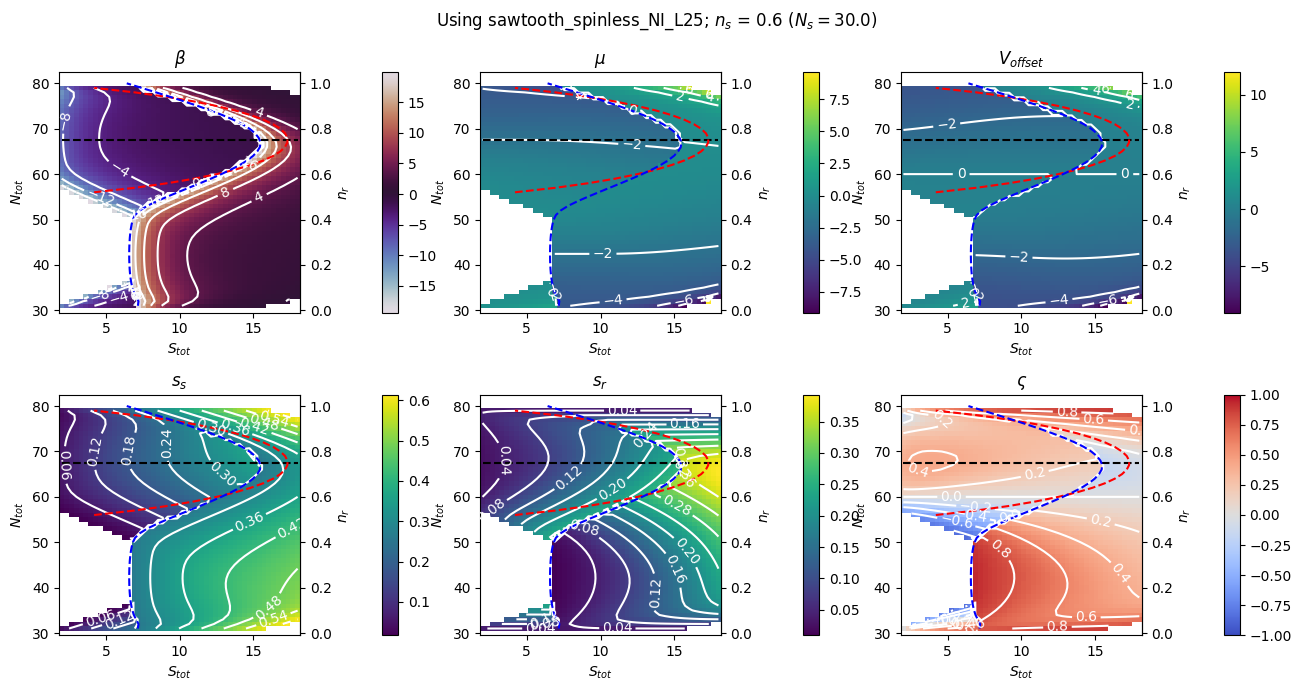

In [23]:
fig_fixS, axs_fixS_all = plt.subplots(2, 3 * 2, figsize = (13, 7), gridspec_kw = {"width_ratios": [15, 1] * 3})
axs_fixS = axs_fixS_all[:, ::2]
axs_fixS_cb = axs_fixS_all[:,1::2]

for ax, ax_cb, params_mat, cmap, str_label, clim in zip(
        axs_fixS.flatten(),
        axs_fixS_cb.flatten(),
        [beta_all, mu_glob_all, V_offset_all, s2_s_all, s2_r_all, varsigma_all],
        ["twilight", "viridis", "viridis", "viridis", "viridis", "coolwarm"],
        [r"$\beta$", r"$\mu$", r"$V_{offset}$", r"$s_s$", r"$s_r$", r"$\varsigma$"],
        [None, None, None, None, None, (-1, 1)]):
    img = ax.pcolormesh(S_range, N_range, params_mat, clim = clim, cmap = cmap)
    ax.set_box_aspect(1)
    ax.set_title(str_label)
    ax.set_xlabel(r"$S_{tot}$")
    ax.set_ylabel(r"$N_{tot}$")
    ryax = ax.secondary_yaxis('right', functions = (lambda x: (x - N_s) / (2 * L_subregion), lambda x: x * 2 * L_subregion + N_s))
    ryax.set_ylabel(r"$n_r$")
    cntr = ax.contour(S_range, N_range, params_mat, colors = "white", linestyles = "solid", levels = 10)
    ax.clabel(cntr, inline = True)
    fig_fixS.colorbar(img, cax = ax_cb, fraction = 0.5, location = 'right')

    ax.plot(S_range, np.full_like(S_range, 0.75 * 2 * L_subregion + N_s), "--k")

    # Plot some limitations set by either physical argument or EoS available
    ax.plot(S_flat(tnpspc['L'], n_r_range), N_range, color = "red", ls = "--")   # minimum S_tot set by flat band
    ax.plot(s2_tot_max_beta, Ntot_max_beta, color = "blue", ls = "--")  # EoS available
fig_fixS.suptitle(rf"Using {folder_name}; $n_s$ = {model_params['n_s']} ($N_s =${N_s})")
fig_fixS.tight_layout(w_pad = 0.1)

I can follow contour lines in the $V_{offset}$ plot and see how things like $s_s$ change. As I type up this section I realized that I don't learn much from this.

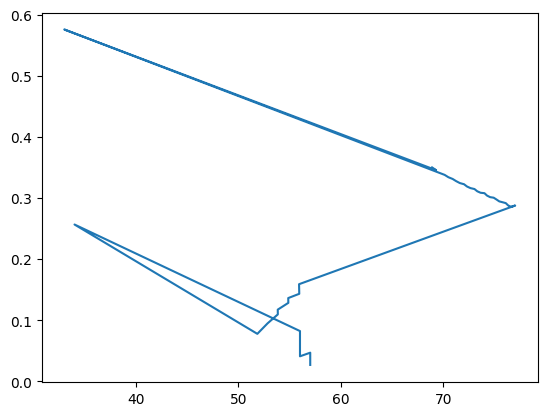

In [24]:
N_curve, s_s_curve = util_thm.slice_constant_V(N_range, S_range, V_offset_all, s2_s_all, 0.25)
plt.plot(N_curve, s_s_curve)

These plots don't answer questions such as:
* Usually we pick some $V_{offset}$ when running the sequence, but the atom number fluctuates a little bit. How are things like $n_s$ and $s_s$ affected?
    * The previous plot doesn't help because it looks at constant $n_s$. What I want is e.g. a 2D grid of $N_{tot} - V_{offset}$ at some $s$, or $S_{tot} - V_{offset}$ at some $N_{tot}$.
* Start with some $N_{tot}$ and $S_{tot}$, and say that I care more about getting the lowest $s_s$ possible than to achieve a certain $n_s$. This is now determined by $V_{offset}$. What does the relation look like?

For these we'll need to read many files with different $n_s$, and for each of them do the inversion for a single (N, S) point. I'll do this in a separate notebook.